In [1]:
# === Step 1: Imports and Load Data ===
import numpy as np
import pandas as pd
from joblib import load
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load the log sequence matrix 
X = load('log_sequence_matrix.joblib')

# Standardize 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [2]:
# Convert Model Output to Binary Labels
def convert_to_binary(predictions, anomaly_value=-1):
    return np.where(predictions == anomaly_value, 1, 0)  # 1 = anomaly
    

In [3]:
# 1. Isolation Forest
iso_model = IsolationForest(random_state=42)
iso_preds = iso_model.fit_predict(X_scaled)
iso_labels = convert_to_binary(iso_preds)


In [4]:
# 2. Local Outlier Factor
lof_model = LocalOutlierFactor(n_neighbors=20, contamination='auto')
lof_preds = lof_model.fit_predict(X_scaled)
lof_labels = convert_to_binary(lof_preds)

In [5]:
# 3. One-Class SVM
svm_model = OneClassSVM(nu=0.05, kernel='rbf', gamma='scale')
svm_preds = svm_model.fit_predict(X_scaled)
svm_labels = convert_to_binary(svm_preds)

In [6]:
# 4. Elliptic Envelope
ee_model = EllipticEnvelope(contamination=0.05)
ee_preds = ee_model.fit_predict(X_scaled)
ee_labels = convert_to_binary(ee_preds)


In [7]:
# 5. DBSCAN
dbscan_model = DBSCAN(eps=1.5, min_samples=5)
dbscan_preds = dbscan_model.fit_predict(X_scaled)
# Treat only noise (-1) as anomaly
dbscan_labels = convert_to_binary(dbscan_preds, anomaly_value=-1)

In [9]:
# Save

labels_df = pd.DataFrame({
    'isolation_forest': iso_labels,
    'local_outlier_factor': lof_labels,
    'one_class_svm': svm_labels,
    'elliptic_envelope': ee_labels,
    'dbscan': dbscan_labels
})

labels_df.index.name = 'window_index'

# to CSV
labels_df.to_csv('unsupervised_labels.csv')

print("Saved to 'unsupervised_labels.csv'")
labels_df.head()


Saved to 'unsupervised_labels.csv'


,isolation_forest,local_outlier_factor,one_class_svm,elliptic_envelope,dbscan
window_index,,,,,
0,1,1,1,1,0
1,1,0,1,1,0
2,1,1,1,1,0
3,1,0,1,1,0
4,1,0,1,1,0


In [10]:
print(labels_df[["dbscan", "isolation_forest", "local_outlier_factor", "one_class_svm", "elliptic_envelope"]].apply(lambda col: (col == 1).sum()))

dbscan                    160
isolation_forest        11647
local_outlier_factor      575
one_class_svm           14100
elliptic_envelope        4566
dtype: int64


In [11]:
vote_matrix = labels_df[["isolation_forest", "local_outlier_factor", "one_class_svm", "elliptic_envelope", "dbscan"]]

# Count how many models flagged each window as anomaly (value = 1)
labels_df["Anomaly_Vote_Sum"] = vote_matrix.sum(axis=1)

# Final label: 1 if at least 3 out of 5 models say it's an anomaly
labels_df["Final_Label"] = labels_df["Anomaly_Vote_Sum"].apply(lambda x: 1 if x >= 3 else 0)

labels_df.to_csv("unsupervised_labels_with_majority.csv")

print("Saved to 'unsupervised_labels_with_majority.csv'")
labels_df[["Anomaly_Vote_Sum", "Final_Label"]].head()


Saved to 'unsupervised_labels_with_majority.csv'


,Anomaly_Vote_Sum,Final_Label
window_index,,
0,4,1
1,3,1
2,4,1
3,3,1
4,3,1


In [12]:
labels_df.mean().sort_values(ascending=False)


Anomaly_Vote_Sum        0.549717
one_class_svm           0.249646
isolation_forest        0.206215
elliptic_envelope       0.080843
Final_Label             0.069086
local_outlier_factor    0.010181
dbscan                  0.002833
dtype: float64

In [13]:
labels_df.corr()


,isolation_forest,local_outlier_factor,one_class_svm,elliptic_envelope,dbscan,Anomaly_Vote_Sum,Final_Label
isolation_forest,1.000000,0.159305,0.102868,0.578809,0.094693,0.740359,0.533620
local_outlier_factor,0.159305,1.000000,-0.019376,0.041743,0.409409,0.223541,0.100342
one_class_svm,0.102868,-0.019376,1.000000,0.392301,0.003892,0.683427,0.454711
elliptic_envelope,0.578809,0.041743,0.392301,1.000000,0.091734,0.808411,0.896295
dbscan,0.094693,0.409409,0.003892,0.091734,1.000000,0.187768,0.178577
Anomaly_Vote_Sum,0.740359,0.223541,0.683427,0.808411,0.187768,1.000000,0.797749
Final_Label,0.533620,0.100342,0.454711,0.896295,0.178577,0.797749,1.000000


In [15]:
labels_df[["isolation_forest","local_outlier_factor","one_class_svm",
           "elliptic_envelope","dbscan"]].corr()


,isolation_forest,local_outlier_factor,one_class_svm,elliptic_envelope,dbscan
isolation_forest,1.000000,0.159305,0.102868,0.578809,0.094693
local_outlier_factor,0.159305,1.000000,-0.019376,0.041743,0.409409
one_class_svm,0.102868,-0.019376,1.000000,0.392301,0.003892
elliptic_envelope,0.578809,0.041743,0.392301,1.000000,0.091734
dbscan,0.094693,0.409409,0.003892,0.091734,1.000000


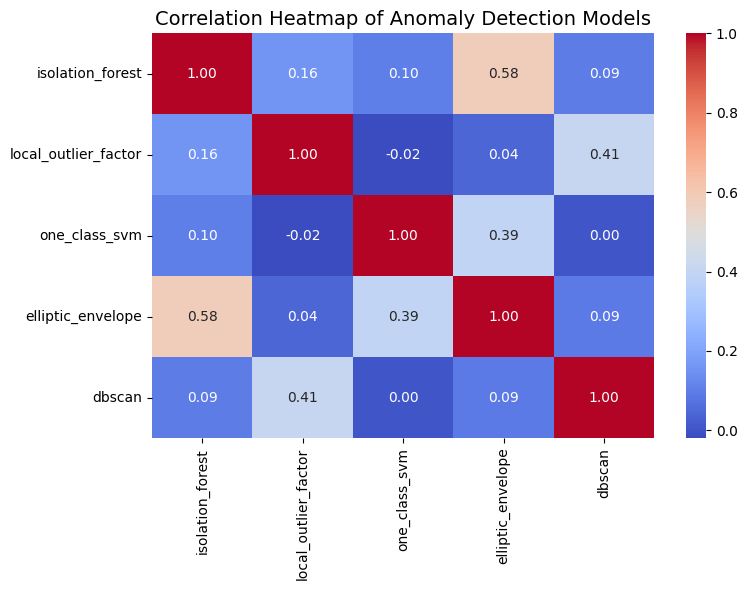

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = labels_df[["isolation_forest","local_outlier_factor",
                         "one_class_svm","elliptic_envelope","dbscan"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

plt.title("Correlation Heatmap of Anomaly Detection Models", fontsize=14)
plt.tight_layout()
plt.show()
